# Music Genre Classification with Machine Learning

In [478]:
# Import libraries and modules
import numpy as np
import pandas as pd
import scipy
import sklearn.preprocessing
import librosa
from librosa import display

import matplotlib.pyplot as plt
import seaborn as sns
seaborn.set(style='ticks')
%matplotlib inline

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report

import os
import fn match

import csv

# For reproducibility
np.random.seed(42)

In [479]:
pd.set_option('display.max_columns', 500)

### Filepath for Feature Extraction

In [ ]:
path = './genres/'

configfiles = [os.path.join(dirpath, f)
    for dirpath, dirnames, files in os.walk(path)
    for f in fnmatch.filter(files, '*.au')]

Sanity check to make sure all files are there...

In [ ]:
len(configfiles)

### Set column names

In [ ]:
header = 'filename chroma_stft spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

### Extract features from audio files

This block of code will extract features from audio, store them in a numpy array, and store these arrays in a .csv file.

### **Note that it may take multiple hours for this cell to run!**

In [ ]:
file = open('gtzan.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in genres:
    for filename in configfiles:
        songname = filename
        y, sr = librosa.load(songname, mono=True, duration=30)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {g}'
        file = open('gtzan.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

Now that all of our features are extracted and stored to .csv, let's examine in a Pandas dataframe to ensure that our data was stored properly.

In [ ]:
df = pd.read_csv('gtzan.csv')
df.head()

In [ ]:
df.shape

In [ ]:
df.duplicated().sum()

In [ ]:
df['label'].value_counts()

Looks like we have quite a few duplicated rows... 9,000 to be exact. We'll drop duplicates and relabel rows appropriately.

In [ ]:
df = df.drop_duplicates(subset=['filename'])
df.shape

In [ ]:
df['label'].value_counts()

In [ ]:
df.loc[100:199, 'label'] = 'classical'

df.loc[200:299, 'label'] = 'country'

df.loc[300:399, 'label'] = 'disco'

df.loc[400:499, 'label'] = 'hiphop'

df.loc[500:599, 'label'] = 'jazz'

df.loc[600:699, 'label'] = 'metal'

df.loc[700:799, 'label'] = 'pop'

df.loc[800:899, 'label'] = 'raggae'

df.loc[900:999, 'label'] = 'rock'

In [ ]:
df['label'].value_counts()

In [ ]:
pd.options.display.max_rows = 1001
df['label']

Now that our data is properly labeled, let's store the cleaned dataframe to a new .csv for use in the modeling process.

In [ ]:
df.to_csv('gtzan_clean.csv')

### Read In Data

In [480]:
df = pd.read_csv('gtzan_clean.csv')
df.head()

,Unnamed: 0,filename,chroma_stft,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,0,./genres/blues/blues.00000.au,0.349943,1784.420446,2002.650192,3806.485316,0.083066,-113.596742,121.557302,-19.158825,42.351029,-6.376457,18.618875,-13.697911,15.344630,-12.285266,10.980491,-8.324323,8.810668,-3.667367,5.751690,-5.162761,0.750947,-1.691937,-0.409954,-2.300208,1.219928,blues
1,1,./genres/blues/blues.00001.au,0.340983,1529.835316,2038.617579,3548.820207,0.056044,-207.556796,124.006717,8.930562,35.874684,2.916038,21.523725,-8.554703,23.358672,-10.103616,11.903744,-5.560387,5.376802,-2.239119,4.216963,-6.012273,0.936109,-0.716537,0.293875,-0.287431,0.531573,blues
2,2,./genres/blues/blues.00002.au,0.363603,1552.481958,1747.165985,3040.514948,0.076301,-90.754394,140.459907,-29.109965,31.689014,-13.987036,25.754761,-13.649586,11.629271,-11.780589,9.706442,-13.123111,5.789265,-8.905224,-1.083720,-9.218359,2.455805,-7.726901,-1.815724,-3.433434,-2.226821,blues
3,3,./genres/blues/blues.00003.au,0.404779,1070.119953,1596.333948,2185.028454,0.033309,-199.431144,150.099218,5.647594,26.871927,1.754463,14.238344,-4.830882,9.297965,-0.757741,8.149012,-3.196314,6.087676,-2.476420,-1.073890,-2.874777,0.780976,-3.316932,0.637981,-0.619690,-3.408233,blues
4,4,./genres/blues/blues.00004.au,0.308590,1835.494603,1748.362448,3580.945013,0.101500,-160.266031,126.198800,-35.605448,22.153301,-32.489270,10.864512,-23.357929,0.503117,-11.805831,1.206804,-13.083820,-2.806385,-6.934122,-7.558619,-9.173552,-4.512166,-5.453538,-0.924162,-4.409333,-11.703781,blues


Drop 'Unnamed: 0,' as it is an artifact of the creation of my initial csv.

In [481]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [482]:
df.head()

,filename,chroma_stft,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,./genres/blues/blues.00000.au,0.349943,1784.420446,2002.650192,3806.485316,0.083066,-113.596742,121.557302,-19.158825,42.351029,-6.376457,18.618875,-13.697911,15.344630,-12.285266,10.980491,-8.324323,8.810668,-3.667367,5.751690,-5.162761,0.750947,-1.691937,-0.409954,-2.300208,1.219928,blues
1,./genres/blues/blues.00001.au,0.340983,1529.835316,2038.617579,3548.820207,0.056044,-207.556796,124.006717,8.930562,35.874684,2.916038,21.523725,-8.554703,23.358672,-10.103616,11.903744,-5.560387,5.376802,-2.239119,4.216963,-6.012273,0.936109,-0.716537,0.293875,-0.287431,0.531573,blues
2,./genres/blues/blues.00002.au,0.363603,1552.481958,1747.165985,3040.514948,0.076301,-90.754394,140.459907,-29.109965,31.689014,-13.987036,25.754761,-13.649586,11.629271,-11.780589,9.706442,-13.123111,5.789265,-8.905224,-1.083720,-9.218359,2.455805,-7.726901,-1.815724,-3.433434,-2.226821,blues
3,./genres/blues/blues.00003.au,0.404779,1070.119953,1596.333948,2185.028454,0.033309,-199.431144,150.099218,5.647594,26.871927,1.754463,14.238344,-4.830882,9.297965,-0.757741,8.149012,-3.196314,6.087676,-2.476420,-1.073890,-2.874777,0.780976,-3.316932,0.637981,-0.619690,-3.408233,blues
4,./genres/blues/blues.00004.au,0.308590,1835.494603,1748.362448,3580.945013,0.101500,-160.266031,126.198800,-35.605448,22.153301,-32.489270,10.864512,-23.357929,0.503117,-11.805831,1.206804,-13.083820,-2.806385,-6.934122,-7.558619,-9.173552,-4.512166,-5.453538,-0.924162,-4.409333,-11.703781,blues


In [483]:
df['label'].value_counts()

disco        100
pop          100
classical    100
blues        100
rock         100
jazz         100
raggae       100
metal        100
country      100
hiphop       100
Name: label, dtype: int64

### Baseline Accuracy

In [484]:
df['label'].value_counts(normalize=True)

disco        0.1
pop          0.1
classical    0.1
blues        0.1
rock         0.1
jazz         0.1
raggae       0.1
metal        0.1
country      0.1
hiphop       0.1
Name: label, dtype: float64

Given the even distribution of our ten labels, our baseline accuracy is 10%. Anything above that is technically an improvement!

### Correlation

I'll check the correlation between my features. This could be useful in determining which type of model to use.

In [485]:
df_corr = df.corr()
df_corr.head()

,chroma_stft,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
chroma_stft,1.000000,0.615524,0.517482,0.597910,0.554735,0.659294,-0.598495,-0.054431,0.264226,-0.010116,0.416953,0.067536,0.509829,0.115721,0.489380,0.072668,0.516620,-0.081725,0.417161,-0.143455,0.332396,-0.163450,0.269791,-0.089906,0.281775
spectral_centroid,0.615524,1.000000,0.904438,0.979633,0.874755,0.720831,-0.940171,0.187999,-0.136839,0.069032,0.017572,0.215744,0.134347,0.288783,0.192851,0.152749,0.174946,0.051260,0.170689,0.022393,0.153678,0.027403,0.228048,0.027761,0.269598
spectral_bandwidth,0.517482,0.904438,1.000000,0.956194,0.612325,0.648373,-0.896660,0.494052,-0.279636,0.302955,-0.066098,0.391085,0.027736,0.409573,0.063432,0.289572,0.038078,0.205272,0.054740,0.127649,0.027062,0.104914,0.114624,0.098151,0.187932
rolloff,0.597910,0.979633,0.956194,1.000000,0.779809,0.721746,-0.934305,0.295590,-0.156114,0.124208,0.034629,0.249704,0.137618,0.311073,0.184945,0.173940,0.162827,0.081738,0.158572,0.032146,0.132326,0.039624,0.205010,0.048121,0.256644
zero_crossing_rate,0.554735,0.874755,0.612325,0.779809,1.000000,0.634139,-0.760127,-0.179883,-0.007672,-0.201045,0.069507,-0.030584,0.197509,0.075159,0.275797,-0.044591,0.263046,-0.142050,0.240698,-0.107069,0.249474,-0.076885,0.297152,-0.074580,0.305031


### Visualizing Correlation with Heatmap

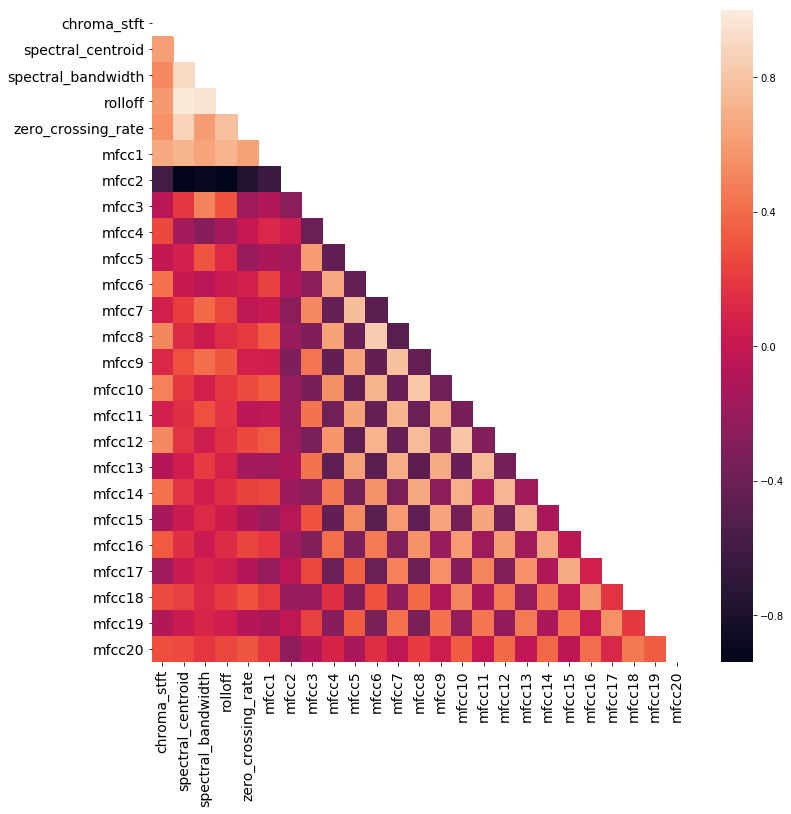

In [486]:
fix, ax = plt.subplots(figsize=(12,12))
mask = np.zeros_like(df_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(df_corr, mask=mask, ax=ax)
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

plt.show()

# Label Encoding & Train/Test Split

The filename won't serve any purpose in training our model(s) and will cause problems in the encoding step, so we'll go ahead and drop that.

In [487]:
filename = df['filename'].copy()

In [488]:
df = df.drop(['filename'],axis=1)

In [489]:
X = df.drop(['label'], axis=1)
y = df['label']

### Encoding our label column

This will translate the 10 categories in our label column into numerical values

In [490]:
encoder = LabelEncoder()
y = pd.Series(encoder.fit_transform(y), index=df.index)

### Split data into training and test sets

In [491]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [492]:
X_train.head()

,chroma_stft,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
29,0.280456,1649.293771,2190.248306,3761.427255,0.052926,-233.724591,101.183595,17.650272,23.734355,2.079372,25.940293,-16.967710,15.094173,-22.278788,4.400507,-23.201637,-6.046127,-5.065351,1.073173,-5.780492,-8.305596,-11.386346,-6.725316,-10.027707,-14.035269
535,0.264579,844.086957,1104.364563,1608.706939,0.037730,-261.855617,182.544415,-16.900182,49.866283,-1.194481,6.327373,6.016987,-8.893297,-10.306515,-3.207951,-5.362567,-3.555686,-2.894215,-7.473875,-0.538052,1.129475,-1.984325,-5.228028,-1.866361,-3.500741
695,0.529131,2445.226841,2330.741065,5191.401942,0.121036,-35.320029,94.132000,-24.248816,43.301719,-16.372783,29.512967,-5.849619,28.460053,-13.954538,13.736810,-9.196753,15.597110,-8.487801,11.407173,-6.134500,9.320328,-6.612436,3.502451,-3.285450,3.665256
557,0.234080,1377.832368,1773.452838,2583.876042,0.061807,-248.102877,125.982812,-12.579262,30.275327,-1.078006,-2.215489,1.941214,0.244143,2.701340,-4.414489,-6.463438,-6.505191,-3.993219,2.331213,0.347861,-4.061490,-1.512878,-3.532444,-6.199395,-7.352205
836,0.434574,1811.515650,2166.351672,4119.275091,0.059239,-236.605975,91.674045,1.857827,45.466646,1.269747,32.261306,9.055936,19.609380,-5.063492,10.958711,-4.015152,7.534469,-0.335024,5.807872,-1.821142,5.382060,0.287280,5.023068,-0.336366,-0.846539


### Scaling Data

In [493]:
scaler = StandardScaler()
X_train_ss = scaler.fit_transform(np.array(X_train, dtype = float))
X_test_ss = scaler.transform(X_test)

### Model A

In [494]:
from keras import models
from keras import layers
from keras import regularizers
from keras.utils import to_categorical

In [495]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

First we'll build our input layers, two hidden layers, and output layer...

In [496]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X_train_ss.shape[1],)))

model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

model.add(layers.Dense(10, activation='softmax'))

...and compile our model.

In [497]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Now we're ready to fit our model.

In [498]:
history = model.fit(X_train_ss,
                    y_train_cat, 
                    validation_data=(X_test_ss, y_test_cat),
                    epochs= 250,
                    batch_size=256);

Train on 800 samples, validate on 200 samples
Epoch 1/250
800/800 [==============================] - 0s 38us/step - loss: 4.7768 - acc: 0.1387 - val_loss: 4.5757 - val_acc: 0.1800
Epoch 2/250
800/800 [==============================] - 0s 16us/step - loss: 4.4573 - acc: 0.3212 - val_loss: 4.3481 - val_acc: 0.2550
Epoch 3/250
800/800 [==============================] - 0s 17us/step - loss: 4.1891 - acc: 0.3400 - val_loss: 4.1338 - val_acc: 0.2650
Epoch 4/250
800/800 [==============================] - 0s 16us/step - loss: 3.9410 - acc: 0.3562 - val_loss: 3.9416 - val_acc: 0.2750
Epoch 5/250
800/800 [==============================] - 0s 18us/step - loss: 3.7150 - acc: 0.3912 - val_loss: 3.7580 - val_acc: 0.3250
Epoch 6/250
800/800 [==============================] - 0s 17us/step - loss: 3.5061 - acc: 0.4462 - val_loss: 3.5685 - val_acc: 0.3450
Epoch 7/250
800/800 [==============================] - 0s 18us/step - loss: 3.3158 - acc: 0.4600 - val_loss: 3.4003 - val_acc: 0.3850
Epoch 8/250
800/

800/800 [==============================] - 0s 20us/step - loss: 0.7421 - acc: 0.8938 - val_loss: 1.6127 - val_acc: 0.6050
Epoch 122/250
800/800 [==============================] - 0s 21us/step - loss: 0.7388 - acc: 0.8975 - val_loss: 1.6049 - val_acc: 0.6000
Epoch 123/250
800/800 [==============================] - 0s 20us/step - loss: 0.7345 - acc: 0.9000 - val_loss: 1.6128 - val_acc: 0.5900
Epoch 124/250
800/800 [==============================] - 0s 24us/step - loss: 0.7498 - acc: 0.8900 - val_loss: 1.6163 - val_acc: 0.6200
Epoch 125/250
800/800 [==============================] - 0s 21us/step - loss: 0.7331 - acc: 0.9012 - val_loss: 1.6465 - val_acc: 0.6100
Epoch 126/250
800/800 [==============================] - 0s 21us/step - loss: 0.7230 - acc: 0.9000 - val_loss: 1.6352 - val_acc: 0.6000
Epoch 127/250
800/800 [==============================] - 0s 23us/step - loss: 0.7349 - acc: 0.8888 - val_loss: 1.6206 - val_acc: 0.6100
Epoch 128/250
800/800 [==============================] - 0s 20

800/800 [==============================] - 0s 20us/step - loss: 0.4994 - acc: 0.9637 - val_loss: 1.7187 - val_acc: 0.6250
Epoch 242/250
800/800 [==============================] - 0s 18us/step - loss: 0.4838 - acc: 0.9700 - val_loss: 1.7129 - val_acc: 0.6300
Epoch 243/250
800/800 [==============================] - 0s 17us/step - loss: 0.4996 - acc: 0.9612 - val_loss: 1.6992 - val_acc: 0.6300
Epoch 244/250
800/800 [==============================] - 0s 20us/step - loss: 0.5275 - acc: 0.9425 - val_loss: 1.7096 - val_acc: 0.6250
Epoch 245/250
800/800 [==============================] - 0s 18us/step - loss: 0.5096 - acc: 0.9612 - val_loss: 1.7189 - val_acc: 0.6150
Epoch 246/250
800/800 [==============================] - 0s 19us/step - loss: 0.4881 - acc: 0.9725 - val_loss: 1.7549 - val_acc: 0.6100
Epoch 247/250
800/800 [==============================] - 0s 18us/step - loss: 0.5091 - acc: 0.9600 - val_loss: 1.6964 - val_acc: 0.6150
Epoch 248/250
800/800 [==============================] - 0s 15

### Model Summary

In [499]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 256)               6656      
_________________________________________________________________
dense_50 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_51 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_52 (Dense)             (None, 10)                650       
Total params: 48,458
Trainable params: 48,458
Non-trainable params: 0
_________________________________________________________________


### Checking for Accuracy

This model is performing with high accuracy on our training set. I have a hunch that this means the model is overfit to the training data. I'll evaluate the model with the testing data, and compare the training accuracy against the testing accuracy.

In [500]:
test_loss, test_acc = model.evaluate(X_test_ss,y_test_cat)

200/200 [==============================] - 0s 23us/step


In [501]:
print('test_acc: ',test_acc)

test_acc:  0.615


As I expected, the model is overfit. I know this because the model performs with 99.88% accuracy on my training data, and only 63% accuracy on my testing data.

### Plot Train & Test Loss

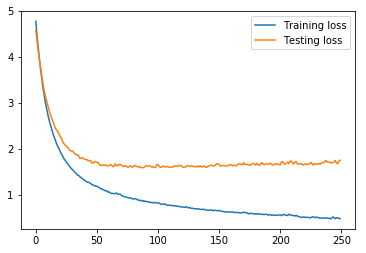

In [502]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']
plt.plot(train_loss, label='Training loss')
plt.plot(test_loss, label='Testing loss')
plt.legend()

### Model A Predictions

In [503]:
predictions = model.predict(X_test_ss)

In [504]:
idx = []
for i in range(len(predictions)):
    idx.append(np.argmax(predictions[i]))

In [505]:
y_test_cats = []
for i in range(len(y_test_cat)):
    y_test_cats.append(np.argmax(y_test_cat[i]))

In [507]:
test_df = pd.DataFrame([y_test_cats, idx])

In [508]:
np.sum(idx[1])

7

In [509]:
np.argmax(idx[1])

0

In [510]:
predictions

array([[2.6638346e-04, 1.8271689e-06, 5.0123554e-06, ..., 1.4259953e-07,
        2.2059799e-06, 2.7684690e-02],
       [1.9426363e-07, 5.1431587e-05, 6.8329964e-03, ..., 7.4261647e-01,
        7.5688131e-02, 1.7742876e-02],
       [1.1230037e-05, 6.5411562e-03, 4.0468842e-01, ..., 5.1606572e-01,
        3.2451462e-03, 5.3219356e-02],
       ...,
       [1.3710214e-03, 1.3107936e-02, 7.3970586e-01, ..., 6.9570094e-02,
        8.6228695e-04, 7.9860024e-02],
       [3.5935495e-06, 6.5362174e-11, 8.8879078e-11, ..., 1.4132312e-13,
        4.6778242e-10, 1.2955112e-06],
       [3.3011761e-01, 5.6970208e-07, 1.4232465e-03, ..., 1.7840113e-08,
        9.8789624e-06, 6.3913846e-01]], dtype=float32)

### F1 Score

In [436]:
nn_F1 = f1_score(y_test_cats, idx, average='macro')
nn_F1

0.6293150578452742

### Neural Network Classification Report

In [437]:
nn_class_report = classification_report(y_test_cats, idx)
print(nn_class_report)

              precision    recall  f1-score   support

           0       0.60      0.60      0.60        20
           1       0.93      1.00      0.96        13
           2       0.65      0.48      0.55        27
           3       0.46      0.62      0.53        21
           4       0.47      0.53      0.50        15
           5       0.79      0.68      0.73        22
           6       0.88      0.88      0.88        25
           7       0.80      0.62      0.70        13
           8       0.50      0.39      0.44        23
           9       0.34      0.48      0.40        21

   micro avg       0.61      0.61      0.61       200
   macro avg       0.64      0.63      0.63       200
weighted avg       0.63      0.61      0.62       200



### Model B

It's really cool that we have neural networks as a tool at our disposal, but this model is not performing very well. Further more, neural networks are referred to as "black boxes," meaning we are unable to determine exactly which spectral features are more important for predicting the genre of a song or which parameters should be tuned in order to improve accuracy on both training and test sets. Furthermore, a neural network may be more useful for classifying genre based on spectrogram images alone, as opposed to a numerical translation of their features. A fun experiment for another time, perhaps!

For now, our dataframe is well-suited for classification using ensemble methods such as a Random Forest Classifier and an ExtraTrees Classifier. These methods are more interpretable than neural networks since we can use SKLearns .feature_importances_ to determine which variables are informative in the model, their inter-tree variability and how they are ranked.

First, I'll build a random forest classifier for this task. Random forest classifiers tend to be very simple to use as they require fewer parameters to set. They also tend to perform very well in general. 

In [438]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier

In [439]:
rf = RandomForestClassifier()

### Gridsearch Over Random Forest

In [440]:
rf_params = {
    'n_estimators': [60, 70, 80],
    'max_depth': [None, 1, 2, 3, 4, 5],
    'min_samples_split': [2,3,4]
}
gs = GridSearchCV(rf, param_grid=rf_params)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

/Users/Christiaan/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/Christiaan/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.6025


{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 80}

In [441]:
gs.score(X_train, y_train)

0.99875

In [442]:
gs.score(X_test, y_test)

0.58

In [443]:
gs.best_params_

{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 80}

### Re-fit Model with Best Parameters

In [444]:
rf = RandomForestClassifier(**gs.best_params_)

In [445]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### Random Forest Feature Importances

In [446]:
rf.feature_importances_

array([0.08335305, 0.03542474, 0.05479655, 0.04933857, 0.04261047,
       0.06022871, 0.03257605, 0.036154  , 0.06326166, 0.03354367,
       0.04394429, 0.03077314, 0.03453628, 0.05044735, 0.02327972,
       0.03786308, 0.03515959, 0.03395603, 0.02982681, 0.03189604,
       0.02885829, 0.04676912, 0.02576069, 0.02767692, 0.02796519])

In [447]:
gs.best_estimator_.feature_importances_

array([0.08453948, 0.03786024, 0.04701638, 0.04978803, 0.03801242,
       0.06567503, 0.0259693 , 0.0396076 , 0.06513841, 0.0333678 ,
       0.04368833, 0.03286015, 0.03260881, 0.04906348, 0.02628229,
       0.03283317, 0.03469772, 0.04069356, 0.02953102, 0.03000409,
       0.02937783, 0.04434701, 0.02841011, 0.02904078, 0.02958695])

In [448]:
rf_feat_imp = sorted([(col, feat) for col, feat in zip(X_train.columns, rf.feature_importances_)], key=lambda x: x[1], reverse=True)

### Plot Feature Importance

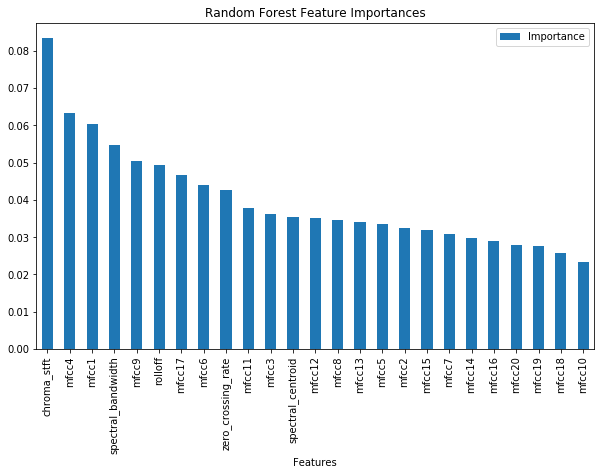

In [449]:
ax = pd.DataFrame(rf_feat_imp, columns=['Features', 'Importance']).set_index('Features').plot(kind='bar', figsize=(10,6), title='Random Forest Feature Importances')

### Random Forest Predictions

In [450]:
predictions = gs.predict(X_test)
predictions

array([6, 7, 7, 6, 4, 6, 6, 5, 3, 1, 8, 3, 6, 3, 3, 4, 9, 5, 7, 4, 5, 1,
       3, 5, 5, 2, 1, 9, 4, 3, 3, 1, 6, 8, 3, 1, 6, 8, 2, 6, 7, 5, 7, 0,
       9, 2, 9, 6, 7, 8, 5, 4, 2, 5, 0, 0, 6, 1, 5, 8, 2, 6, 5, 7, 4, 9,
       6, 8, 9, 5, 1, 4, 5, 2, 0, 2, 6, 0, 5, 3, 6, 9, 0, 0, 7, 5, 0, 8,
       2, 4, 3, 4, 5, 2, 7, 8, 3, 0, 0, 8, 7, 3, 3, 0, 6, 6, 5, 2, 1, 9,
       5, 6, 9, 3, 0, 8, 1, 9, 5, 2, 8, 4, 8, 0, 2, 0, 4, 7, 7, 3, 5, 3,
       5, 9, 9, 6, 1, 3, 5, 0, 0, 2, 7, 2, 2, 8, 0, 8, 4, 7, 6, 1, 3, 4,
       9, 4, 3, 6, 6, 2, 5, 7, 6, 6, 2, 6, 2, 6, 3, 3, 3, 4, 1, 2, 8, 4,
       9, 0, 8, 6, 4, 3, 9, 5, 4, 1, 4, 4, 4, 2, 5, 8, 6, 1, 2, 4, 3, 2,
       6, 9])

In [451]:
filename[X_test.index]

521              ./genres/jazz/jazz.00021.au
737                ./genres/pop/pop.00037.au
740                ./genres/pop/pop.00040.au
660            ./genres/metal/metal.00060.au
411          ./genres/hiphop/hiphop.00011.au
678            ./genres/metal/metal.00078.au
626            ./genres/metal/metal.00026.au
513              ./genres/jazz/jazz.00013.au
859          ./genres/reggae/reggae.00059.au
136    ./genres/classical/classical.00036.au
811          ./genres/reggae/reggae.00011.au
76             ./genres/blues/blues.00076.au
636            ./genres/metal/metal.00036.au
973              ./genres/rock/rock.00073.au
938              ./genres/rock/rock.00038.au
899          ./genres/reggae/reggae.00099.au
280        ./genres/country/country.00080.au
883          ./genres/reggae/reggae.00083.au
761                ./genres/pop/pop.00061.au
319            ./genres/disco/disco.00019.au
549              ./genres/jazz/jazz.00049.au
174    ./genres/classical/classical.00074.au
371       

### Predicted Classical

Can we verify this with our ears?

In [476]:
import IPython.display as ipd
from IPython.display import Audio
ipd.Audio('./genres/classical/classical.00036.au')

### Predicted Rock

In [477]:
import IPython.display as ipd
from IPython.display import Audio
ipd.Audio('./genres/country/country.00080.au')

### Random Forest Classifier F1

In [452]:
rf_F1 = f1_score(y_test, predictions, average='macro')
rf_F1

0.5790332286168883

### Random Forest Classifier Classification Report

In [453]:
rf_class_report = classification_report(y_test, predictions)
print(rf_class_report)

              precision    recall  f1-score   support

           0       0.50      0.45      0.47        20
           1       0.93      1.00      0.96        13
           2       0.59      0.48      0.53        27
           3       0.46      0.52      0.49        21
           4       0.41      0.60      0.49        15
           5       0.71      0.77      0.74        22
           6       0.79      0.88      0.83        25
           7       0.47      0.54      0.50        13
           8       0.47      0.35      0.40        23
           9       0.44      0.33      0.38        21

   micro avg       0.58      0.58      0.58       200
   macro avg       0.58      0.59      0.58       200
weighted avg       0.58      0.58      0.57       200



### Model C

The random forest model above is also overfitting to the training data. Below, I'll fit an Extra Trees model in hopes of combatting some of the correlation between observations that was observed above.

In [454]:
from sklearn.ensemble import ExtraTreesClassifier

In [455]:
et = ExtraTreesClassifier()

### Gridsearch Over Extra Trees Classifier

In [456]:
et_params = {
    'n_estimators': [30, 40, 50],
    'max_depth': [None, 1, 2, 3, 4, 5],
    'min_samples_split': [2,3,4]
}
gs = GridSearchCV(et, param_grid=et_params)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

/Users/Christiaan/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.60125


/Users/Christiaan/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 40}

In [457]:
gs.score(X_train, y_train)

0.99875

In [458]:
gs.score(X_test, y_test)

0.62

### Re-fit Model with Best Parameters

In [459]:
et = ExtraTreesClassifier(**gs.best_params_)

In [460]:
et.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

### Random Forest Feature Importances

In [461]:
et.feature_importances_

array([0.06478849, 0.05258538, 0.04809015, 0.04453473, 0.04060556,
       0.06171263, 0.03410902, 0.03785731, 0.05693009, 0.03274055,
       0.04235061, 0.03716123, 0.03520571, 0.04538102, 0.03009263,
       0.03792433, 0.03609477, 0.04189797, 0.03020783, 0.03309859,
       0.03097302, 0.03850968, 0.02630542, 0.03056519, 0.0302781 ])

In [462]:
gs.best_estimator_.feature_importances_

array([0.06623227, 0.04663472, 0.04800861, 0.04956231, 0.03650167,
       0.0614536 , 0.03593415, 0.03805462, 0.05365743, 0.03221822,
       0.04272909, 0.03847743, 0.03966316, 0.04652429, 0.03191204,
       0.03742241, 0.03231963, 0.03783453, 0.03148262, 0.03231566,
       0.03060964, 0.04024717, 0.02848919, 0.03000793, 0.03170762])

In [463]:
et_feat_imp = sorted([(col, feat) for col, feat in zip(X_train.columns, et.feature_importances_)], key=lambda x: x[1], reverse=True)

### Plot Feature Importance

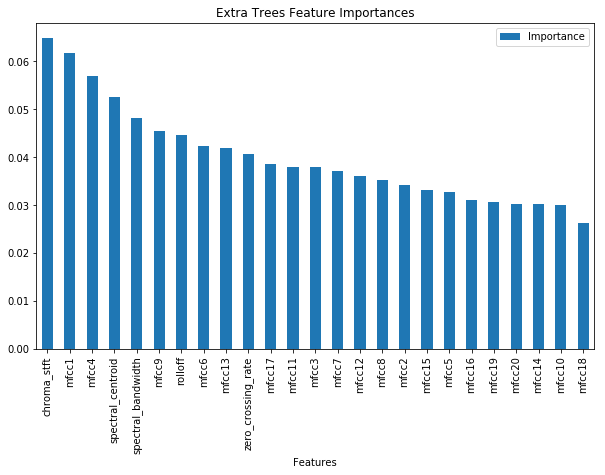

In [464]:
ax = pd.DataFrame(et_feat_imp, columns=['Features', 'Importance']).set_index('Features').plot(kind='bar', figsize=(10,6), title='Extra Trees Feature Importances')

In [465]:
predictions = gs.predict(X_test)
predictions

array([6, 7, 2, 6, 4, 6, 6, 5, 4, 1, 8, 6, 6, 3, 3, 4, 9, 2, 7, 4, 3, 1,
       3, 5, 5, 2, 1, 9, 4, 9, 3, 1, 6, 8, 3, 1, 6, 5, 0, 6, 3, 5, 2, 0,
       9, 2, 9, 6, 2, 8, 5, 4, 0, 5, 5, 0, 6, 5, 5, 8, 2, 6, 5, 7, 6, 2,
       6, 8, 9, 5, 1, 4, 5, 9, 6, 2, 6, 0, 5, 3, 6, 9, 4, 0, 7, 5, 9, 8,
       7, 4, 3, 4, 1, 2, 7, 8, 4, 0, 0, 8, 7, 3, 3, 2, 6, 6, 5, 2, 1, 9,
       5, 6, 9, 4, 0, 8, 1, 9, 5, 2, 8, 4, 8, 2, 2, 9, 5, 2, 9, 3, 0, 2,
       5, 9, 9, 0, 1, 2, 0, 0, 0, 2, 7, 2, 8, 8, 9, 9, 4, 7, 6, 1, 6, 2,
       7, 4, 3, 6, 0, 2, 5, 7, 6, 6, 8, 6, 2, 6, 3, 4, 3, 4, 1, 2, 4, 4,
       0, 2, 0, 6, 4, 3, 3, 1, 7, 1, 6, 4, 9, 7, 5, 8, 6, 1, 2, 4, 3, 3,
       6, 6])

In [466]:
filename[X_test.index]

521              ./genres/jazz/jazz.00021.au
737                ./genres/pop/pop.00037.au
740                ./genres/pop/pop.00040.au
660            ./genres/metal/metal.00060.au
411          ./genres/hiphop/hiphop.00011.au
678            ./genres/metal/metal.00078.au
626            ./genres/metal/metal.00026.au
513              ./genres/jazz/jazz.00013.au
859          ./genres/reggae/reggae.00059.au
136    ./genres/classical/classical.00036.au
811          ./genres/reggae/reggae.00011.au
76             ./genres/blues/blues.00076.au
636            ./genres/metal/metal.00036.au
973              ./genres/rock/rock.00073.au
938              ./genres/rock/rock.00038.au
899          ./genres/reggae/reggae.00099.au
280        ./genres/country/country.00080.au
883          ./genres/reggae/reggae.00083.au
761                ./genres/pop/pop.00061.au
319            ./genres/disco/disco.00019.au
549              ./genres/jazz/jazz.00049.au
174    ./genres/classical/classical.00074.au
371       

### Extra Trees F1

In [467]:
et_F1 = f1_score(y_test, predictions, average='macro')
et_F1

0.6203594797090328

### Extra Trees Classification Report

In [468]:
et_class_report = classification_report(y_test, predictions)
print(et_class_report)

              precision    recall  f1-score   support

           0       0.65      0.55      0.59        20
           1       0.87      1.00      0.93        13
           2       0.58      0.56      0.57        27
           3       0.63      0.57      0.60        21
           4       0.41      0.60      0.49        15
           5       0.68      0.68      0.68        22
           6       0.72      0.92      0.81        25
           7       0.62      0.62      0.62        13
           8       0.60      0.39      0.47        23
           9       0.47      0.43      0.45        21

   micro avg       0.62      0.62      0.62       200
   macro avg       0.62      0.63      0.62       200
weighted avg       0.62      0.62      0.61       200

